<div style="
    background: linear-gradient(135deg, #0f2027, #203a43, #2c5364);
    padding: 38px 42px;
    border-radius: 22px;
    color: #f9fafb;
    box-shadow: 0 18px 45px rgba(0,0,0,0.45);
    margin-bottom: 36px;
    text-align: center;
">

  <h1 style="
      font-size: 44px;
      font-weight: 800;
      margin: 0 0 12px 0;
      letter-spacing: 0.6px;
  ">
    🧠 Human Emotion Recognition
  </h1>

  <h3 style="
      font-size: 20px;
      font-weight: 500;
      margin: 0;
      color: #d1d5db;
  ">
    Deep Learning with CNNs on FER-2013
  </h3>

  <hr style="
      border: none;
      height: 1.5px;
      background: linear-gradient(to right, #e5e7eb, rgba(255,255,255,0.1));
      margin: 20px 0;
  ">

  <p style="
      font-size: 17px;
      line-height: 1.7;
      margin: 0 auto;
      color: #e5e7eb;
      max-width: 920px;
      text-align: center;
  ">
    An end-to-end <b>Facial Emotion Recognition</b> notebook featuring image preprocessing,
    data augmentation, a <b>custom CNN built from scratch</b>, and detailed performance analysis
    including learning curves, confusion matrix, and prediction visualizations.
  </p>

</div>


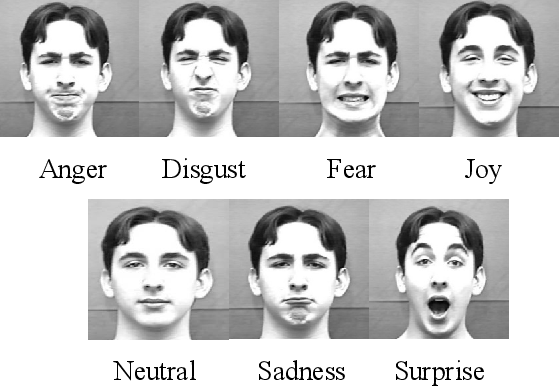
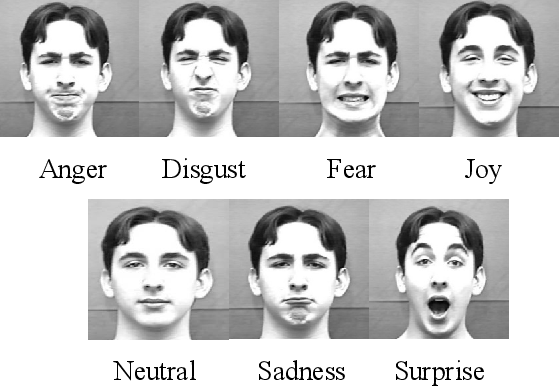
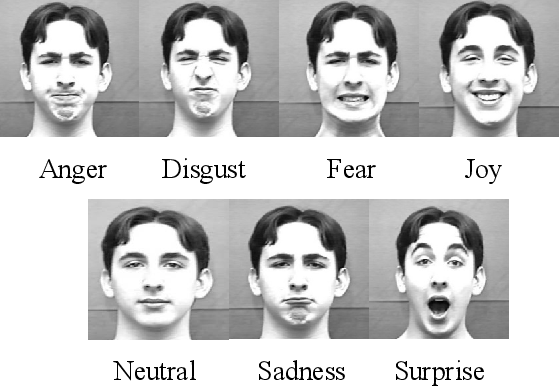
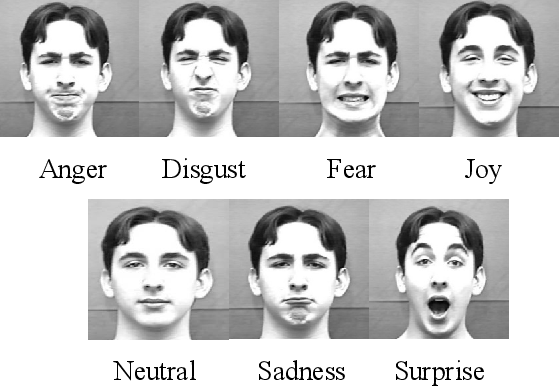

<a id="1"></a>
<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    1 | Introduction
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>


Facial Emotion Recognition (FER) is a challenging computer vision problem due to:

- Low-resolution images (48×48)
- High intra-class similarity
- Strong class imbalance
- Noisy human annotations

In this notebook, we build a **deep CNN from scratch using PyTorch**, carefully tune it for the FER-2013 dataset, and analyze its behavior using **training curves, confusion matrix, and prediction visualizations**.

🎯 **Final Result:**  
**Validation Accuracy ≈ 66–67%**, which is close to the practical ceiling for plain CNNs on FER-2013.


<a id="2"></a>
<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    2 | Import Libraries
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random


import warnings
warnings.filterwarnings("ignore")


<a id="3"></a>
<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    3 | Device Configuration
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>

We enable **GPU acceleration** to significantly speed up deep learning training.
PyTorch automatically switches between CPU and GPU depending on availability.

💡 Using GPU can reduce training time by **10-100x** compared to CPU!

In [2]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<a id="4"></a>
<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    4 | Hyperparameters
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>

In [3]:
BATCH_SIZE = 64
LR = 5e-4
EPOCHS = 60
NUM_CLASSES = 7


<a id="5"></a>
<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    5 | Data Preprocessing & Augmentation
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>


In [4]:
train_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


<a id="6"></a>
<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    6 | Dataset Overview
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>


We use the **FER2013** dataset, a popular benchmark for facial emotion recognition.

### 🔹 Dataset Details
- Image size: **48 × 48**
- Image type: **Grayscale**
- Number of classes: **7**

### 🔹 Emotion Classes
- 😊 Happy
- 😢 Sad
- 😠 Angry
- 😨 Fear
- 😲 Surprise
- 😐 Neutral
- 🤢 Disgust

The dataset is organized into folders by emotion category,
making it easy to load using PyTorch's `ImageFolder`.

### 6.1 | Load the dataset

In [5]:
train_dataset = datasets.ImageFolder(
    "/kaggle/input/fer2013/train",
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    "/kaggle/input/fer2013/test",
    transform=val_transform
)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=2, pin_memory=True
)

print("Classes:", train_dataset.classes)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


### 6.2 | Sample Images Visualization

Let's visualize sample images from each emotion category to understand the dataset:

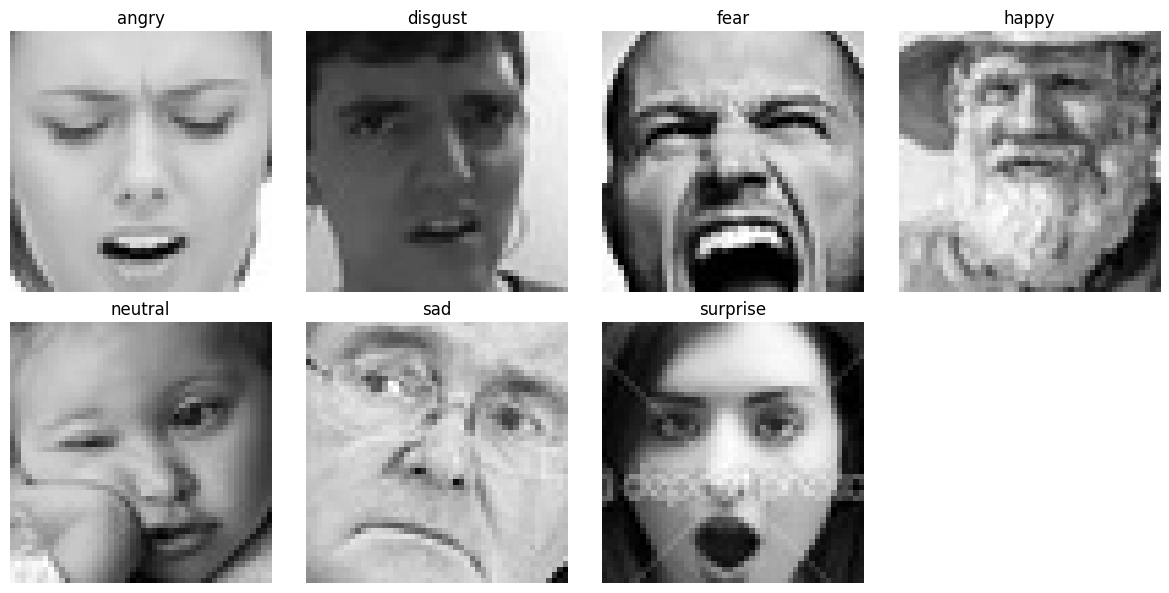

In [6]:

root_dir = train_dataset.root
classes = train_dataset.classes

plt.figure(figsize=(12,6))

for i, emotion in enumerate(classes):
    class_dir = os.path.join(root_dir, emotion)
    img_name = os.listdir(class_dir)[0]
    img_path = os.path.join(class_dir, img_name)
    img = plt.imread(img_path)

    plt.subplot(2,4,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(emotion)
    plt.axis("off")

plt.tight_layout()
plt.show()

Random samples from the Train set help visualize:

- Low resolution of inputs
- Subtle facial expressions
- Dataset noise

Despite these challenges, the model learns meaningful patterns.

<a id="7"></a>
<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    7 | Class Imbalance Handling
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>



In [7]:
targets = [y for _, y in train_dataset.samples]
class_count = Counter(targets)

weights = torch.tensor(
    [1.0 / class_count[i] for i in range(NUM_CLASSES)],
    dtype=torch.float
).to(device)


<a id="8"></a>
<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    8 | CNN Model Architecture
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>

### 🏗️ Architecture Overview:
We use a **deep Convolutional Neural Network** with the following design principles:

- Progressive feature extraction (64 → 512 channels)
- Batch Normalization for training stability
- Dropout for regularization
- Fully connected classifier head

### Architecture Summary

**Input:** `48 × 48 × 1`

### Feature Extraction Pipeline
- Convolution → Batch Normalization → ReLU → Max Pooling  
- Convolution → Batch Normalization → ReLU → Max Pooling  
- Convolution → Batch Normalization → ReLU → Max Pooling  
- Convolution → Batch Normalization → ReLU → Max Pooling  

### Classification Head
- Fully Connected Layers  
- **7-Class Output**

### Design Rationale
This architecture strikes a careful balance between **model capacity** and **generalization**, which is especially important for **Facial Emotion Recognition (FER)** tasks where datasets are relatively small and prone to overfitting.


### 8.1 | CNN from Scratch

In [8]:
class FER_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 3 * 3, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),

            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),

            nn.Linear(512, NUM_CLASSES)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

model = FER_CNN().to(device)




### ⚙️ Training Strategy
To improve performance and stability, we apply:

- **Data Augmentation**
  - Random horizontal flip
  - Small rotations
- **Class-weighted CrossEntropy Loss**
  - Addresses class imbalance
- **Learning Rate Scheduler**
  - Reduces LR when validation accuracy plateaus

### 8.2 | Training Setup

In [9]:
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LR)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=3
)


<a id="9"></a>
<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    9 | Training Loop
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>

In [10]:
train_loss, train_acc = [], []
val_loss, val_acc = [], []

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    loss_sum, correct, total = 0, 0, 0

    with torch.set_grad_enabled(train):
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            if train:
                optimizer.zero_grad()

            out = model(x)
            loss = criterion(out, y)

            if train:
                loss.backward()
                optimizer.step()

            loss_sum += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    return loss_sum / len(loader), correct / total


for epoch in range(EPOCHS):
    tr_l, tr_a = run_epoch(train_loader, True)
    va_l, va_a = run_epoch(val_loader, False)

    scheduler.step(va_a)

    train_loss.append(tr_l)
    train_acc.append(tr_a)
    val_loss.append(va_l)
    val_acc.append(va_a)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Acc: {tr_a:.4f} | Val Acc: {va_a:.4f}"
    )


Epoch [1/60] | Train Acc: 0.2323 | Val Acc: 0.2747
Epoch [2/60] | Train Acc: 0.3229 | Val Acc: 0.3752
Epoch [3/60] | Train Acc: 0.3838 | Val Acc: 0.4310
Epoch [4/60] | Train Acc: 0.4333 | Val Acc: 0.4826
Epoch [5/60] | Train Acc: 0.4672 | Val Acc: 0.4975
Epoch [6/60] | Train Acc: 0.4969 | Val Acc: 0.5372
Epoch [7/60] | Train Acc: 0.5088 | Val Acc: 0.5306
Epoch [8/60] | Train Acc: 0.5170 | Val Acc: 0.5660
Epoch [9/60] | Train Acc: 0.5343 | Val Acc: 0.5497
Epoch [10/60] | Train Acc: 0.5421 | Val Acc: 0.5752
Epoch [11/60] | Train Acc: 0.5484 | Val Acc: 0.5627
Epoch [12/60] | Train Acc: 0.5567 | Val Acc: 0.5848
Epoch [13/60] | Train Acc: 0.5586 | Val Acc: 0.5665
Epoch [14/60] | Train Acc: 0.5524 | Val Acc: 0.5789
Epoch [15/60] | Train Acc: 0.5685 | Val Acc: 0.5899
Epoch [16/60] | Train Acc: 0.5820 | Val Acc: 0.6045
Epoch [17/60] | Train Acc: 0.5895 | Val Acc: 0.5942
Epoch [18/60] | Train Acc: 0.5976 | Val Acc: 0.6167
Epoch [19/60] | Train Acc: 0.5986 | Val Acc: 0.5997
Epoch [20/60] | Train

<a id="10"></a>
<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    10 | Training & Validation Performance
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>

### 10.1 | Training vs Validation Accuracy

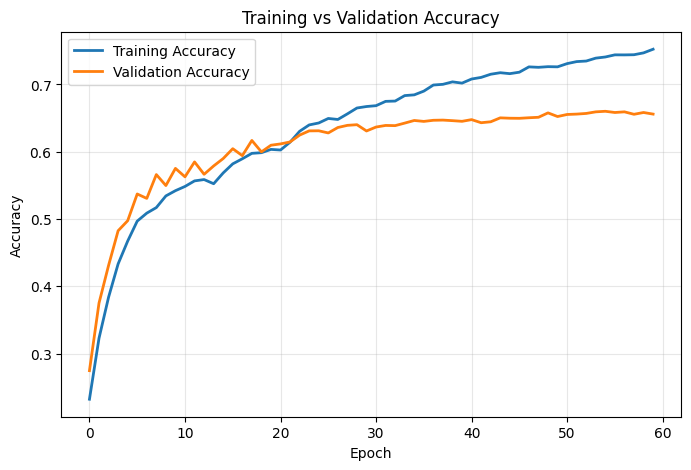

In [11]:
plt.figure(figsize=(8,5))
plt.plot(train_acc, label="Training Accuracy", linewidth=2)
plt.plot(val_acc, label="Validation Accuracy", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


The plot below shows the evolution of training and validation accuracy.

**Observations:**
- Rapid improvement during early epochs
- Validation accuracy plateaus around **66–67%**
- Gap between train and validation indicates mild overfitting

This behavior is expected for FER-2013 and confirms that the model has learned most of the available signal.


### 10.2 Training vs Validation Loss

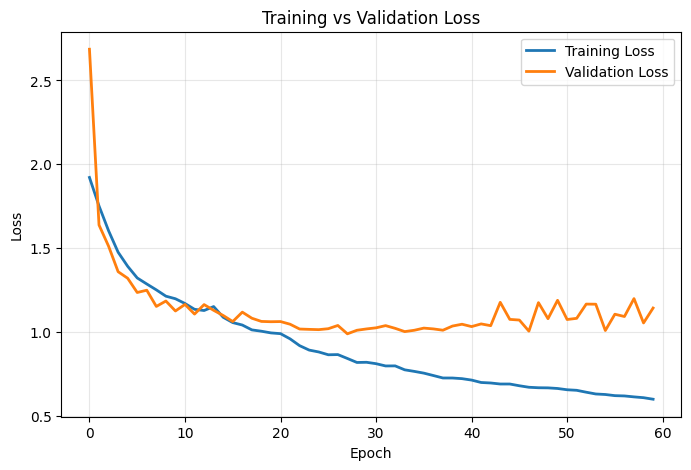

In [12]:
plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Training Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()




Loss curves demonstrate:

- Smooth optimization
- No signs of divergence
- Stabilization after ~40 epochs

Further training beyond this point yields diminishing returns.

<a id="11"></a>
<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    11 | Confusion Matrix
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>

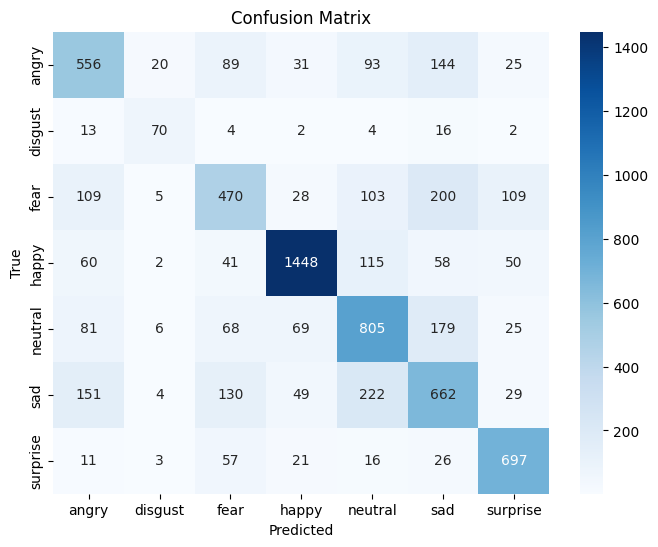

In [13]:
from sklearn.metrics import confusion_matrix

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=train_dataset.classes,
    yticklabels=train_dataset.classes
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


<a id="12"></a>
<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    12 | Prediction Gallery
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>

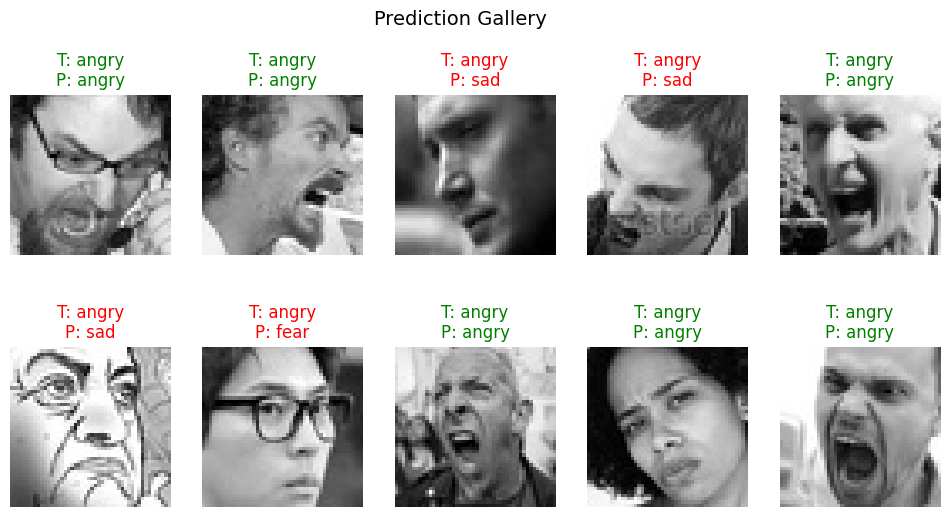

In [14]:
model.eval()
plt.figure(figsize=(12,6))
shown = 0

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)

        for i in range(x.size(0)):
            if shown >= 10:
                break

            img = x[i].cpu().squeeze()
            true = train_dataset.classes[y[i]]
            pred = train_dataset.classes[preds[i]]

            plt.subplot(2,5,shown+1)
            plt.imshow(img, cmap="gray")
            plt.title(
                f"T: {true}\nP: {pred}",
                color="green" if true == pred else "red"
            )
            plt.axis("off")
            shown += 1

        if shown >= 10:
            break

plt.suptitle("Prediction Gallery", fontsize=14)
plt.show()


<a id="13"></a>
<div style="margin:34px 0 22px 0;">
  <h2 style="
      font-family: 'Inter', 'Segoe UI', Roboto, Arial, sans-serif;
      font-size:28px;
      font-weight:800;
      color: #93c5fd;        
      margin:0;
      letter-spacing:0.4px;
  ">
    12 | Conclusion & Next Steps
  </h2>

  <hr style="
      border:none;
      height:1.5px;
      background: linear-gradient(to right, #3b82f6, #1f2937);
      margin-top:12px;
  ">
</div>

This notebook demonstrates that:

- Plain CNNs can reach **~67% accuracy** on FER-2013
- Further gains require architectural changes rather than more epochs

### Possible Extensions
- Upgrade to **ResNet18** or **EfficientNet**
- Apply **Vision Transformers (ViT)**
- Use **Grad-CAM** for interpretability

---

> **Takeaway:**  
> When validation accuracy plateaus, it is not a failure — it is a signal that the model has learned what it can.

Thank you for reading! ⭐
If you found this notebook **helpful, insightful, or inspiring**, please consider giving it an **⬆️ upvote**.